In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

games = pd.read_csv('./data/games.csv')
details = pd.read_csv('./data/games_details.csv')
injuries = pd.read_csv('./data/injuries_2010-2020.csv')
teams = pd.read_csv('./data/teams.csv')

#Helper function to force pandas to display full dataframes
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [49]:
teams

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends
5,0,1610612743,1976,2019,DEN,Nuggets,1976,Denver,Pepsi Center,19099.0,Stan Kroenke,Tim Connelly,Michael Malone,No Affiliate
6,0,1610612745,1967,2019,HOU,Rockets,1967,Houston,Toyota Center,18104.0,Tilman Fertitta,Daryl Morey,Mike D'Antoni,Rio Grande Valley Vipers
7,0,1610612746,1970,2019,LAC,Clippers,1970,Los Angeles,Staples Center,19060.0,Steve Ballmer,Michael Winger,Doc Rivers,Agua Caliente Clippers of Ontario
8,0,1610612747,1948,2019,LAL,Lakers,1948,Los Angeles,Staples Center,19060.0,Jerry Buss Family Trust,Rob Pelinka,Frank Vogel,South Bay Lakers
9,0,1610612748,1988,2019,MIA,Heat,1988,Miami,AmericanAirlines Arena,19600.0,Micky Arison,Pat Riley,Erik Spoelstra,Sioux Falls Skyforce


In [2]:
#We will drop the Acquired column for now, it might be possible to do analysis on 
#players returning from injuries but let's ignore it for now

injuries = injuries.drop('Acquired',axis=1)
injuries = injuries[injuries.Relinquished.notnull()]
injuries.update(injuries['Team'].fillna(value='No team', inplace=True))

#Charlotte Hornets were formerly the Bobcats before 2014, so we should count their injuries as
#part of the Hornets

injuries['Team'] = np.where((injuries.Team == 'Bobcats'), 'Hornets', injuries.Team)

#Let's copy the injuries dataset into a new dataframe
injuries_classes = injuries.copy()

#We'll use a lambda to create 3 different class labels for ML
injuries_classes['Notes'] = injuries_classes['Notes'].apply(lambda x: 
        1 if 'rest' in x 
        else 1 if 'rest' in x
        else 0)
        
#Renaming the 'Notes' column to 'Class'
injuries_classes = injuries_classes.rename({'Notes': 'Injury', 'Relinquished': 'Player', 'year': 'Year'}, axis='columns')

#String formatting and removal of Jr. and periods from rows in Player column
injuries_classes['Player'] = injuries_classes['Player'].astype("string")
injuries_classes['Player'] = injuries_classes['Player'].str.replace('Jr.','')
injuries_classes['Player'] = injuries_classes['Player'].str.replace('.','')
injuries_classes['Player'] = injuries_classes['Player'].str.strip()

details['PLAYER_NAME'] = details['PLAYER_NAME'].astype("string")

#Formatting of both games and injuries to use pd Datetime format for merging
injuries_classes['Date'] = pd.to_datetime(injuries_classes['Date'],format='%Y-%m-%d')

games['GAME_DATE_EST'] = pd.to_datetime(games['GAME_DATE_EST'],format='%Y-%m-%d')

#Enumeration of NBA Season dates in a dictionary. Seems unnecessary if using
#pd.merge_asof to merge datasets
nba_seasons = {
        "2010-11": ["2010-10-26","2011-06-12"],
        "2011-12": ["2011-12-25","2012-06-21"],
        "2012-13": ["2012-10-30","2013-06-20"],
        "2013-14": ["2013-"]
}

injuries_classes

,Date,Team,Player,Injury
0,2010-10-03,Bulls,Carlos Boozer,0
1,2010-10-06,Pistons,Jonas Jerebko,0
2,2010-10-06,Pistons,Terrico White,0
3,2010-10-08,Blazers,Jeff Ayres,0
4,2010-10-08,Nets,Troy Murphy,0
...,...,...,...,...
27097,2020-09-22,Celtics,Romeo Langford,0
27098,2020-09-23,Heat,Gabe Vincent,0
27099,2020-09-30,Heat,Bam Adebayo,0
27101,2020-10-02,Heat,Bam Adebayo,0


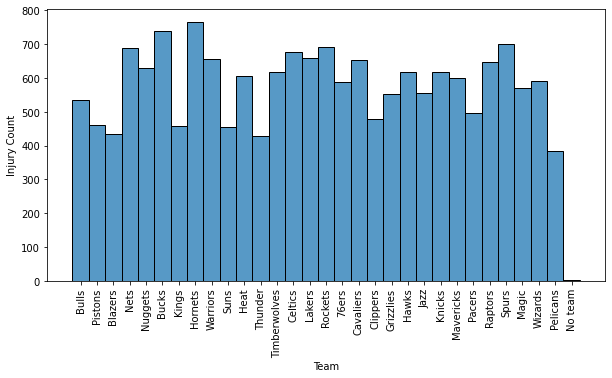

In [3]:
plt.figure(figsize=(10,5))
chart = sns.histplot(x='Team',data=injuries)
plt.xticks(rotation=90)
plt.ylabel('Injury Count')
plt.show()

In [4]:
games = games.drop_duplicates(subset=['GAME_ID'])
games = games[["GAME_DATE_EST","GAME_ID","SEASON", "HOME_TEAM_ID", "VISITOR_TEAM_ID"]]
games.head()

,GAME_DATE_EST,GAME_ID,SEASON,HOME_TEAM_ID,VISITOR_TEAM_ID
0,2021-11-17,22100213,2021,1610612766,1610612764
1,2021-11-17,22100214,2021,1610612765,1610612754
2,2021-11-17,22100215,2021,1610612737,1610612738
3,2021-11-17,22100216,2021,1610612751,1610612739
4,2021-11-17,22100217,2021,1610612748,1610612740


In [5]:
games_sorted = games.sort_values(by=['GAME_DATE_EST'])
games_sorted[games_sorted.SEASON.astype(int) >= 2010]

,GAME_DATE_EST,GAME_ID,SEASON,HOME_TEAM_ID,VISITOR_TEAM_ID
7803,2010-10-04,11000003,2010,1610612750,1610612747
7797,2010-10-05,11000011,2010,1610612748,1610612765
7795,2010-10-05,11000004,2010,1610612739,1610612766
7796,2010-10-05,11000007,2010,1610612755,1610612751
7799,2010-10-05,11000005,2010,1610612745,1610612753
...,...,...,...,...,...
5,2021-11-17,22100218,2021,1610612752,1610612753
4,2021-11-17,22100217,2021,1610612748,1610612740
3,2021-11-17,22100216,2021,1610612751,1610612739
1,2021-11-17,22100214,2021,1610612765,1610612754


In [46]:
#Dataframes that are to be merged by merge_asof need to be sorted first
df = details.merge(games, on=['GAME_ID'])
df = df.sort_values(by=['GAME_DATE_EST'],ascending=True)
df = df[df.SEASON.astype(int) >= 2010]
df = df[df.SEASON.astype(int) < 2020]
df['b2b'] = 0
df



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,GAME_DATE_EST,SEASON,HOME_TEAM_ID,VISITOR_TEAM_ID,b2b
326869,11000003,1610612750,MIN,Minnesota,201593,Nikola Pekovic,NaN,NaN,NaN,12,1.0,1.0,1.000,0.0,0.0,0.000,5.0,6.0,0.833,0.0,3.0,3.0,2.0,1.0,0.0,1.0,5.0,7.0,NaN,2010-10-04,2010,1610612750,1610612747,0
326870,11000003,1610612750,MIN,Minnesota,201961,Wayne Ellington,NaN,NaN,NaN,20,4.0,10.0,0.400,1.0,2.0,0.500,0.0,0.0,0.000,0.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,9.0,NaN,2010-10-04,2010,1610612750,1610612747,0
326867,11000003,1610612750,MIN,Minnesota,101110,Martell Webster,NaN,NaN,NaN,30,8.0,13.0,0.615,3.0,5.0,0.600,5.0,7.0,0.714,0.0,2.0,2.0,1.0,0.0,0.0,2.0,0.0,24.0,NaN,2010-10-04,2010,1610612750,1610612747,0
326866,11000003,1610612750,MIN,Minnesota,2557,Luke Ridnour,NaN,NaN,NaN,28,3.0,6.0,0.500,0.0,0.0,0.000,0.0,0.0,0.000,0.0,1.0,1.0,7.0,4.0,0.0,2.0,4.0,6.0,NaN,2010-10-04,2010,1610612750,1610612747,0
326863,11000003,1610612750,MIN,Minnesota,201567,Kevin Love,NaN,NaN,NaN,26,3.0,5.0,0.600,1.0,1.0,1.000,4.0,4.0,1.000,1.0,7.0,8.0,6.0,0.0,1.0,1.0,2.0,11.0,NaN,2010-10-04,2010,1610612750,1610612747,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42144,41900406,1610612748,MIA,Miami,1629639,Tyler Herro,NaN,G,NaN,30:22,3.0,10.0,0.300,1.0,2.0,0.500,0.0,0.0,0.000,0.0,3.0,3.0,4.0,1.0,0.0,4.0,1.0,7.0,4.0,2020-10-11,2019,1610612748,1610612747,0
42143,41900406,1610612748,MIA,Miami,1629130,Duncan Robinson,NaN,G,NaN,34:10,3.0,8.0,0.375,3.0,7.0,0.429,1.0,1.0,1.000,0.0,1.0,1.0,3.0,0.0,0.0,2.0,3.0,10.0,-16.0,2020-10-11,2019,1610612748,1610612747,0
42142,41900406,1610612748,MIA,Miami,1628389,Bam Adebayo,NaN,C,NaN,42:13,10.0,15.0,0.667,0.0,0.0,0.000,5.0,9.0,0.556,1.0,9.0,10.0,5.0,0.0,2.0,2.0,2.0,25.0,-21.0,2020-10-11,2019,1610612748,1610612747,0
42141,41900406,1610612748,MIA,Miami,203109,Jae Crowder,NaN,F,NaN,27:40,3.0,9.0,0.333,1.0,5.0,0.200,5.0,7.0,0.714,1.0,3.0,4.0,1.0,1.0,0.0,0.0,4.0,12.0,-13.0,2020-10-11,2019,1610612748,1610612747,0


In [51]:
plt.figure(figsize=(10,5))
points_chart = df[['TEAM_ID', 'PTS']]
points_chart = points_chart.merge(teams, on=['TEAM_ID'])
points_chart

,TEAM_ID,PTS,LEAGUE_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,1610612750,7.0,0,1989,2019,MIN,Timberwolves,1989,Minnesota,Target Center,19356.0,Glen Taylor,Scott Layden,Ryan Saunders,Iowa Wolves
1,1610612750,9.0,0,1989,2019,MIN,Timberwolves,1989,Minnesota,Target Center,19356.0,Glen Taylor,Scott Layden,Ryan Saunders,Iowa Wolves
2,1610612750,24.0,0,1989,2019,MIN,Timberwolves,1989,Minnesota,Target Center,19356.0,Glen Taylor,Scott Layden,Ryan Saunders,Iowa Wolves
3,1610612750,6.0,0,1989,2019,MIN,Timberwolves,1989,Minnesota,Target Center,19356.0,Glen Taylor,Scott Layden,Ryan Saunders,Iowa Wolves
4,1610612750,11.0,0,1989,2019,MIN,Timberwolves,1989,Minnesota,Target Center,19356.0,Glen Taylor,Scott Layden,Ryan Saunders,Iowa Wolves
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349778,1610612740,NaN,0,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
349779,1610612740,8.0,0,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
349780,1610612740,9.0,0,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
349781,1610612740,0.0,0,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate


<Figure size 720x360 with 0 Axes>

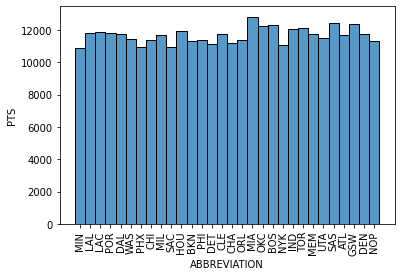

In [52]:
chart = sns.histplot(x='ABBREVIATION',data=points_chart)
plt.xticks(rotation=90)
plt.ylabel('PTS')
plt.show()

In [7]:
def find_b2b_players(df_games_team, df_games_players):
    teams = df_games_team.HOME_TEAM_ID.unique()
    teams.sort()
    temp_dict = {}
    temp_dataframe = df_games_team.copy()
    df_games_players_temp = df_games_players.copy()
    df_games_players_temp['b2b'] = 0

    #go through each team and find difference in time between games
    for team in teams:
        df_games_temp = df_games_team[((df_games_team['HOME_TEAM_ID'] == team) | (df_games_team['VISITOR_TEAM_ID'] == team))].copy()
        df_temp = df_games_temp.copy()
        #find time between each game
        df_temp['diff'] = df_temp['GAME_DATE_EST'].diff()
        #print(df_temp['diff'].head())
        #if diff = 1 day save game_id and team_id
        for i in df_temp[df_temp['diff']=='1 days'].index:
            temp_dict[df_temp['GAME_ID'][i]] = team

    for key in temp_dict:
        df_games_players_temp.loc[((df_games_players_temp.GAME_ID == key) & (df_games_players_temp.TEAM_ID == temp_dict[key])), ['b2b']] = 1
    return(df_games_players_temp)

In [8]:
df_temp = find_b2b_players(games_sorted, df)
df_temp['b2b'].value_counts()

0    292952
1     56831
Name: b2b, dtype: int64

In [9]:
df_temp.isna().sum()

GAME_ID                   0
TEAM_ID                   0
TEAM_ABBREVIATION         0
TEAM_CITY                 0
PLAYER_ID                 0
PLAYER_NAME               0
NICKNAME             349783
START_POSITION       217203
COMMENT              290655
MIN                   59129
FGM                   59129
FGA                   59129
FG_PCT                59129
FG3M                  59129
FG3A                  59129
FG3_PCT               59129
FTM                   59129
FTA                   59129
FT_PCT                59129
OREB                  59129
DREB                  59129
REB                   59129
AST                   59129
STL                   59129
BLK                   59129
TO                    59129
PF                    59129
PTS                   59129
PLUS_MINUS            67915
GAME_DATE_EST             0
SEASON                    0
HOME_TEAM_ID              0
VISITOR_TEAM_ID           0
b2b                       0
dtype: int64

In [10]:
asofmerge = pd.merge_asof(df_temp, injuries_classes, left_on=['GAME_DATE_EST'], right_on=['Date'],direction='nearest',left_by=['PLAYER_NAME'],right_by=['Player'],tolerance=pd.Timedelta("1W"))
asofmerge = asofmerge.sort_values(by=['GAME_DATE_EST'])
asofmerge['SEASON'] = pd.to_numeric(asofmerge['SEASON'])
asofmerge = asofmerge[asofmerge.SEASON >= 2010]
asofmerge = asofmerge[asofmerge.SEASON < 2020]

def formatInjury(x):
    if pd.isnull(x) : return 0
    else : return 1
s = asofmerge.loc[:,'Injury']
s = s.apply(formatInjury)
asofmerge['Injury'] = s
asofmerge = asofmerge.drop(['Player','Team','Date','START_POSITION','COMMENT','PLUS_MINUS', 'NICKNAME'],axis=1)
asofmerge[['PLAYER_NAME','TEAM_CITY','GAME_DATE_EST','Injury','SEASON']]


,PLAYER_NAME,TEAM_CITY,GAME_DATE_EST,Injury,SEASON
0,Nikola Pekovic,Minnesota,2010-10-04,0,2010
25,Metta World Peace,Los Angeles,2010-10-04,0,2010
23,Drew Naymick,Los Angeles,2010-10-04,0,2010
22,Kobe Bryant,Los Angeles,2010-10-04,0,2010
21,Lamar Odom,Los Angeles,2010-10-04,0,2010
...,...,...,...,...,...
349758,Kyle Kuzma,Los Angeles,2020-10-11,0,2019
349757,Quinn Cook,Los Angeles,2020-10-11,0,2019
349781,Jae Crowder,Miami,2020-10-11,0,2019
349768,Jared Dudley,Los Angeles,2020-10-11,0,2019


In [11]:
injuries_games_dropped = asofmerge.dropna(axis=0,how='any').copy()

def seconder(x):
    if pd.isnull(x) : return 0
    elif ':' not in x :
        return float(x)*60.0
    else :
        mins, secs = map(float, str(x).split(':'))
        return mins * 60 + secs

s = injuries_games_dropped.loc[:,('MIN')].copy()
s = s.apply(seconder)
s = s.convert_dtypes()
s = pd.to_numeric(s, errors='coerce').convert_dtypes()
injuries_games_dropped.loc[:,('MIN')] = s.copy()
injuries_games_dropped = injuries_games_dropped.rename({'MIN': 'SECS'}, axis='columns')
injuries_games_dropped

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,SECS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,GAME_DATE_EST,SEASON,HOME_TEAM_ID,VISITOR_TEAM_ID,b2b,Injury
0,11000003,1610612750,MIN,Minnesota,201593,Nikola Pekovic,720,1.0,1.0,1.000,0.0,0.0,0.0,5.0,6.0,0.833,0.0,3.0,3.0,2.0,1.0,0.0,1.0,5.0,7.0,2010-10-04,2010,1610612750,1610612747,0,0
25,11000003,1610612747,LAL,Los Angeles,1897,Metta World Peace,1020,1.0,3.0,0.333,0.0,0.0,0.0,1.0,2.0,0.500,1.0,0.0,1.0,2.0,2.0,0.0,1.0,1.0,3.0,2010-10-04,2010,1610612750,1610612747,0,0
23,11000003,1610612747,LAL,Los Angeles,202404,Drew Naymick,780,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,1.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2010-10-04,2010,1610612750,1610612747,0,0
22,11000003,1610612747,LAL,Los Angeles,977,Kobe Bryant,360,0.0,3.0,0.000,0.0,2.0,0.0,0.0,0.0,0.000,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,2010-10-04,2010,1610612750,1610612747,0,0
21,11000003,1610612747,LAL,Los Angeles,1885,Lamar Odom,1620,6.0,10.0,0.600,0.0,3.0,0.0,5.0,11.0,0.455,2.0,4.0,6.0,1.0,3.0,0.0,3.0,3.0,17.0,2010-10-04,2010,1610612750,1610612747,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349758,41900406,1610612747,LAL,Los Angeles,1628398,Kyle Kuzma,1316,1.0,4.0,0.250,0.0,2.0,0.0,0.0,0.0,0.000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,2.0,2020-10-11,2019,1610612748,1610612747,0,0
349757,41900406,1610612747,LAL,Los Angeles,1626188,Quinn Cook,87,0.0,1.0,0.000,0.0,1.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-10-11,2019,1610612748,1610612747,0,0
349781,41900406,1610612748,MIA,Miami,203109,Jae Crowder,1660,3.0,9.0,0.333,1.0,5.0,0.2,5.0,7.0,0.714,1.0,3.0,4.0,1.0,1.0,0.0,0.0,4.0,12.0,2020-10-11,2019,1610612748,1610612747,0,0
349768,41900406,1610612747,LAL,Los Angeles,201162,Jared Dudley,87,0.0,1.0,0.000,0.0,1.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-10-11,2019,1610612748,1610612747,0,0


In [12]:
mldf = injuries_games_dropped.drop(['TEAM_ID','GAME_ID','PLAYER_ID','PLAYER_NAME','TEAM_ABBREVIATION','TEAM_CITY','GAME_DATE_EST','SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID'],axis=1)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 2000)
#mldf['MIN'] = mldf['MIN'].astype(str)
cols = list(mldf.columns.values)
inj = cols.pop(cols.index('Injury'))
mldf = mldf[cols+[inj]]
#mldf = mldf.groupby(['Player']).transform(lambda x: x.fillna(x.mean()))
mldf

,SECS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,b2b,Injury
0,720,1.0,1.0,1.000,0.0,0.0,0.0,5.0,6.0,0.833,0.0,3.0,3.0,2.0,1.0,0.0,1.0,5.0,7.0,0,0
25,1020,1.0,3.0,0.333,0.0,0.0,0.0,1.0,2.0,0.500,1.0,0.0,1.0,2.0,2.0,0.0,1.0,1.0,3.0,0,0
23,780,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,1.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0,0
22,360,0.0,3.0,0.000,0.0,2.0,0.0,0.0,0.0,0.000,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0,0
21,1620,6.0,10.0,0.600,0.0,3.0,0.0,5.0,11.0,0.455,2.0,4.0,6.0,1.0,3.0,0.0,3.0,3.0,17.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349758,1316,1.0,4.0,0.250,0.0,2.0,0.0,0.0,0.0,0.000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,2.0,0,0
349757,87,0.0,1.0,0.000,0.0,1.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
349781,1660,3.0,9.0,0.333,1.0,5.0,0.2,5.0,7.0,0.714,1.0,3.0,4.0,1.0,1.0,0.0,0.0,4.0,12.0,0,0
349768,87,0.0,1.0,0.000,0.0,1.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [16]:
injuries_season_team = injuries_games_dropped.groupby(['SEASON','TEAM_ABBREVIATION']).agg({'Injury': 'sum','SECS': 'mean', 'PTS': 'mean', 'FGM': 'mean', 'FGA': 'mean', 'FG_PCT': 'mean', 'FG3M': 'mean', 'FG3A': 'mean', 'b2b': 'mean'})

In [14]:
injuries_season_player = injuries_games_dropped.groupby(['SEASON','PLAYER_NAME']).agg({'Injury': 'sum','SECS': 'mean', 'PTS': 'mean', 'FGM': 'sum', 'FGA': 'sum', 'FG_PCT': 'mean', 'FG3M': 'sum', 'FG3A': 'sum', 'b2b': 'sum'})


In [19]:
points_season_team = injuries_games_dropped.groupby(['SEASON','TEAM_ABBREVIATION']).agg({'Injury': 'sum','SECS': 'mean', 'PTS': 'sum', 'FGM': 'mean', 'FGA': 'mean', 'FG_PCT': 'mean', 'FG3M': 'mean', 'FG3A': 'mean', 'b2b': 'mean'})
points_season_team



Injury         SECS  ...      FG3A       b2b
SEASON TEAM_ABBREVIATION                       ...                    
2010   ATL                   101  1388.179829  ...  1.626070  0.195052
       BOS                   150  1403.987267  ...  1.338883  0.183154
       CHA                   146  1368.191824  ...  1.352201  0.255765
       CHI                    64  1382.117700  ...  1.664870  0.170710
       CLE                   141  1413.315385  ...  1.748352  0.121978
...                          ...          ...  ...       ...       ...
2019   SAC                    78  1370.632019  ...  3.305854  0.124253
       SAS                    59  1268.785161  ...  2.447398  0.108527
       TOR                   113  1344.283798  ...  3.479876  0.119711
       UTA                   108  1335.490323  ...  3.256989  0.097849
       WAS                    84  1339.266745  ...  3.072855  0.117509

[300 rows x 9 columns]

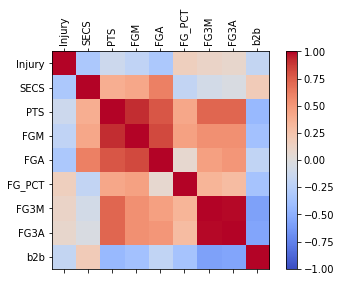

In [15]:
corr = injuries_season_team.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(injuries_season_team.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(injuries_season_team.columns)
ax.set_yticklabels(injuries_season_team.columns)
plt.show()

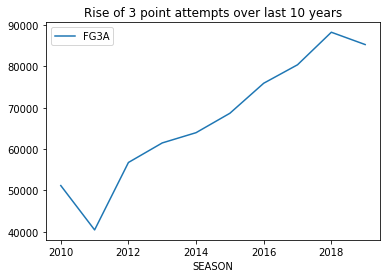

In [16]:
three_point_shots = injuries_games_dropped.groupby(['SEASON']).agg({'FG3A': 'sum'})


three_point_shots.plot(title = 'Rise of 3 point attempts over last 10 years')

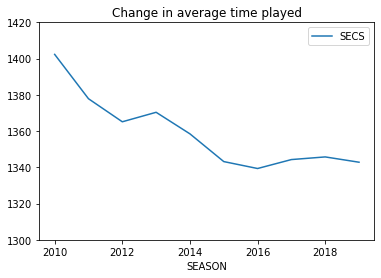

In [17]:
game_time = injuries_games_dropped.groupby(['SEASON']).agg({'SECS': 'mean'})

game_time.plot(title = 'Change in average time played', ylim = [1300,1420])

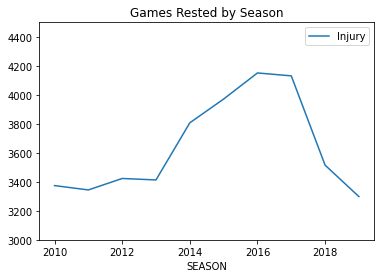

In [23]:
game_time = injuries_games_dropped.groupby(['SEASON']).agg({'Injury': 'sum'})

game_time.plot(title = 'Games Rested by Season',  ylim = [3000,4500])

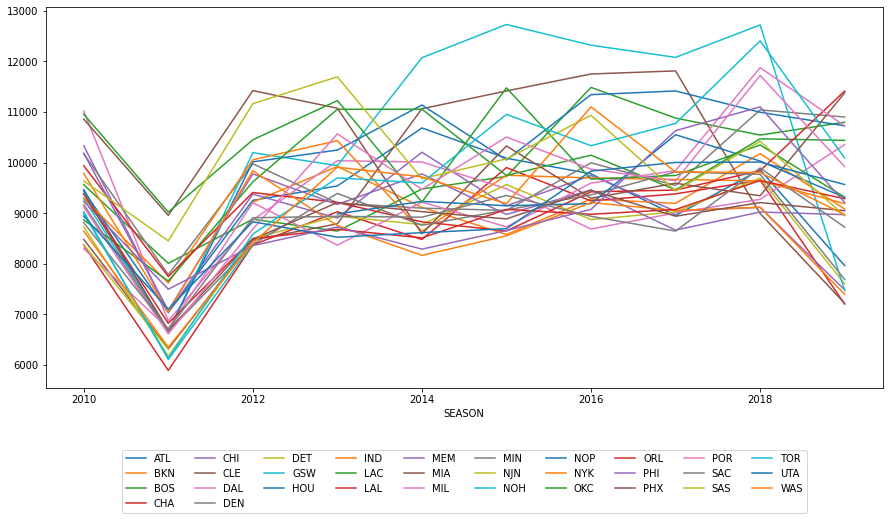

In [36]:
game_time = injuries_games_dropped.groupby(['SEASON', 'TEAM_ABBREVIATION']).agg({'PTS': 'sum'})
game_time
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
injuries_games_dropped.groupby(['SEASON','TEAM_ABBREVIATION']).sum()['PTS'].unstack().plot(ax=ax)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol= 10)

In [19]:
injuries_team = injuries_games_dropped.groupby(['TEAM_ABBREVIATION']).agg({'Injury': 'sum','SECS': 'mean', 'PTS': 'mean', 'FGM': 'mean', 'FGA': 'mean', 'FG_PCT': 'mean', 'FG3M': 'mean', 'FG3A': 'mean', 'b2b': 'mean'})

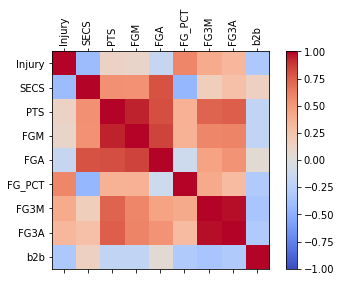

In [20]:
corr = injuries_team.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(injuries_team.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(injuries_team.columns)
ax.set_yticklabels(injuries_team.columns)
plt.show()